In [1]:
!pip install SciencePlots

  Using cached SciencePlots-2.0.1-py3-none-any.whl (15 kB)


In [2]:
import numpy as np
from utils.data_loader import DataLoader
from utils.plotting import optimal_bin_size
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
import scienceplots
import time
from joblib import delayed, Parallel
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns
plt.style.use(['science','no-latex', 'ieee'])
plt.rcParams.update({
    "font.family": "DejaVu Sans",   # specify font family here
})

In [3]:
def reset_rc_params():
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({
        "font.family": "DejaVu Sans",   # specify font family here
    })
    plt.style.use(['science','no-latex', 'ieee'])
    return
reset_rc_params()

In [4]:
root_dir = '/scratch/shivansh.seth/adni/preproc'
SCRATCH_DATA_DIR = '/scratch/shivansh.seth/tmp/'
PRINT_TIME_INTERVAL = 20
if not os.path.exists(SCRATCH_DATA_DIR): os.makedirs(SCRATCH_DATA_DIR)
dloader = DataLoader(root_dir)
sk = np.load('skull_indices_flat.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/shivansh.seth/adni/preproc'

In [ ]:
def linear_map(signal, ignore_nans=True, top_k=10):
    if not type(signal) is np.ndarray:
        signal = np.array(signal)
    arr_sorted = np.sort(signal)
    a = np.mean(arr_sorted[-top_k:])
    b = np.mean(arr_sorted[:top_k])
#     if ignore_nans:
#         a, b = np.nanmax(signal), np.nanmin(signal)
#     else:
#         a, b = max(signal), min(signal)
    
    return (2*signal-(a+b))/(a - b)

def binarize(signal):
    arr_sorted = np.sort(signal)
    avg_max = np.mean(arr_sorted[-10:])
    avg_min = np.mean(arr_sorted[:10])
    cutoff = (avg_max + avg_min)/2
    lindices = signal>cutoff
    rindices = signal <= cutoff
    signal[lindices] = 1
    signal[rindices] = 0
    return signal

In [ ]:
trs = []
for i in range(89):
    fimg = dloader.get_func(i)
    tr = fimg.header.get_zooms()[3]
    trs.append(tr)
trs = np.array(trs)

In [ ]:
trs = trs[trs<3.1]
print(len(trs))
max(trs), min(trs)

In [ ]:
def get_power_spectrum(fdata, tr = 3, tmax=140):
    shape = fdata.shape
    fdata_ss = fdata.reshape(-1, shape[-1])[sk, :tmax]
    print(fdata_ss.shape)
    fs = 1/tr
    freq = np.arange(tmax)*fs/tmax
    psds = np.ones((fdata_ss.shape[0], tmax//2))
#     print(len(freq)//2)
    for i in range(fdata_ss.shape[0]): 
        fdata_k = np.fft.fft(linear_map(fdata_ss[i]))   
        psd = np.abs(fdata_k)**2
        psds[i] = psd[:tmax//2]
    return psds

In [ ]:
fdata = dloader.get_func(9).get_fdata()
shape = fdata.shape
fdata_ss = fdata.reshape(-1, shape[-1])[sk]
lm_data = np.apply_along_axis(linear_map, 1, fdata_ss)
# plt.hist(lm_data[:10].flatten())

In [ ]:
# ad_psds = []
# cnt = 0
# for sub in dloader.ad_subs:
#     print(cnt)
#     cnt+=1
#     fimg = dloader.get_func(sub)
#     tr = fimg.header.get_zooms()[3]
#     fdata = fimg.get_fdata()
    
#     if tr < 3.03 and tr > 2.97 and fdata.shape[3] >= 140:
#         res = get_power_spectrum(fdata, )
#         ad_psds.append(res)
# print('AD done')
# ad_psds = np.array(ad_psds)

In [5]:
# cn_psds = []
# cnt = 0
# cn_subs = [sub for idx, sub in enumerate(dloader.subjects_list) if dloader.diag[idx] == 0]
# for sub in cn_subs:
#     print(cnt)
#     cnt+=1
#     fimg = dloader.get_func(sub)
#     tr = fimg.header.get_zooms()[3]
#     fdata = fimg.get_fdata()
#     if tr < 3.03 and tr > 2.97 and fdata.shape[3] >= 140:
#         res = get_power_spectrum(fdata)
#         cn_psds.append(res)
# cn_psds = np.array(cn_psds)

In [7]:
# os.mkdir('./results/psds/')
# np.save('results/psds/ad_psds', ad_psds)
# np.save('results/psds/cn_psds', cn_psds)
ad_psds = np.load('results/psds/ad_psds.npy')
cn_psds = np.load('results/psds/cn_psds.npy')


In [8]:
cn_psd_log = np.log10(cn_psds.reshape(-1, cn_psds.shape[-1]))
ad_psd_log = np.log10(ad_psds.reshape(-1, ad_psds.shape[-1]))
fs = 1/3
tmax = 140
freq = np.arange(tmax//2)*fs/(tmax//2)
freq.shape, cn_psd_log.shape

((70,), (1641588, 70))

In [ ]:
marker_size = 3
trunc_start, trunc_end = 1, -1
pcolors = [ ["#E74C3C", "#B82E1E", "#96231C", "#F7D8D3"], ["#16A085", "#0F8166", "#186C57", "#CCF5EA"], ["#2ECC40", "#1F9D2E"] ]
linewidth = 2.5

log_freq = np.log10(freq)
cn_y_mean = np.nanmean(cn_psd_log, axis=0)
cn_y_std = np.nanstd(cn_psd_log, axis=0)
cn_fit = np.polyfit(log_freq[trunc_start: trunc_end], cn_y_mean[trunc_start: trunc_end], 1)
cn_std_fit = np.polyfit(log_freq[trunc_start: trunc_end], cn_y_mean[trunc_start: trunc_end], 1)
print(f"CN fit: {cn_fit[0]}")

ad_y_mean = np.nanmean(ad_psd_log, axis=0)
ad_y_std = np.nanstd(ad_psd_log, axis=0)
ad_fit = np.polyfit(log_freq[trunc_start: trunc_end], ad_y_mean[trunc_start: trunc_end], 1)
print(f"AD fit: {ad_fit[0]}")
plt.fill_between(log_freq, cn_y_mean + cn_y_std, cn_y_mean - cn_y_std, rasterized=True, color=pcolors[0][3], alpha=1)
plt.plot(log_freq, cn_y_mean + cn_y_std, rasterized=True, color=pcolors[0][1], linestyle='-', alpha=0.6)
plt.plot(log_freq, cn_y_mean - cn_y_std, rasterized=True, color=pcolors[0][1], linestyle='-', alpha=0.6)

plt.fill_between(log_freq, ad_y_mean + ad_y_std, ad_y_mean - ad_y_std, rasterized=True, color=pcolors[1][3], alpha=0.5)
plt.plot(log_freq, ad_y_mean + ad_y_std, rasterized=True, color=pcolors[1][1], linestyle='-', alpha=0.6)
plt.plot(log_freq, ad_y_mean - ad_y_std, rasterized=True, color=pcolors[1][1], linestyle='-', alpha=0.6)
cn_label = "$m_{CN} = " + f"{cn_fit[0]:.3f}$\n"
plt.scatter(log_freq, cn_y_mean, s=marker_size, rasterized=True, color=pcolors[0][0])
plt.plot(log_freq, np.polyval(cn_fit, log_freq), label=cn_label, linestyle='--', rasterized=True, alpha=1, color=pcolors[0][1], linewidth=linewidth)

ad_label = "$m_{AD} = " + f"{ad_fit[0]:.3f}$\n"
plt.scatter(log_freq, ad_y_mean, s=marker_size, rasterized=True, color=pcolors[1][0])
plt.plot(log_freq, np.polyval(ad_fit, log_freq),label=ad_label, linestyle='--', rasterized=True, alpha=0.5, color=pcolors[1][1], linewidth=linewidth)

# m_label = "$m =" + f"{-1}$"
# plt.plot(log_freq, np.log10(1/freq), label=m_label, linestyle='--', rasterized=True, color='black')
plt.legend()
plt.ylabel('$log_{10}(S(f))$')
plt.xlabel('$log_{10}(f)$')
plt.savefig('results/plots/psds.svg', dpi=1200)
plt.savefig('results/plots/psds.pdf', dpi=1200)
plt.show()
reset_rc_params()

In [15]:
ad_exps = []
cn_exps = []
for i in ad_psd_log:
    ad_fit = np.polyfit(log_freq[trunc_start: trunc_end], i[trunc_start: trunc_end], 1)
    ad_exps.append(ad_fit[0])
for i in cn_psd_log:
    cn_fit = np.polyfit(log_freq[trunc_start: trunc_end], i[trunc_start: trunc_end], 1)
    cn_exps.append(cn_fit[0])

In [16]:
np.nanstd(ad_exps), np.nanstd(cn_exps)

(0.45595091992299935, 0.44026951968244077)

In [17]:
len(ad_exps), len(cn_exps), len(ad_exps + cn_exps)

(1073346, 1641588, 2714934)

In [18]:
ad_exps, cn_exps = np.array(ad_exps), np.array(cn_exps)

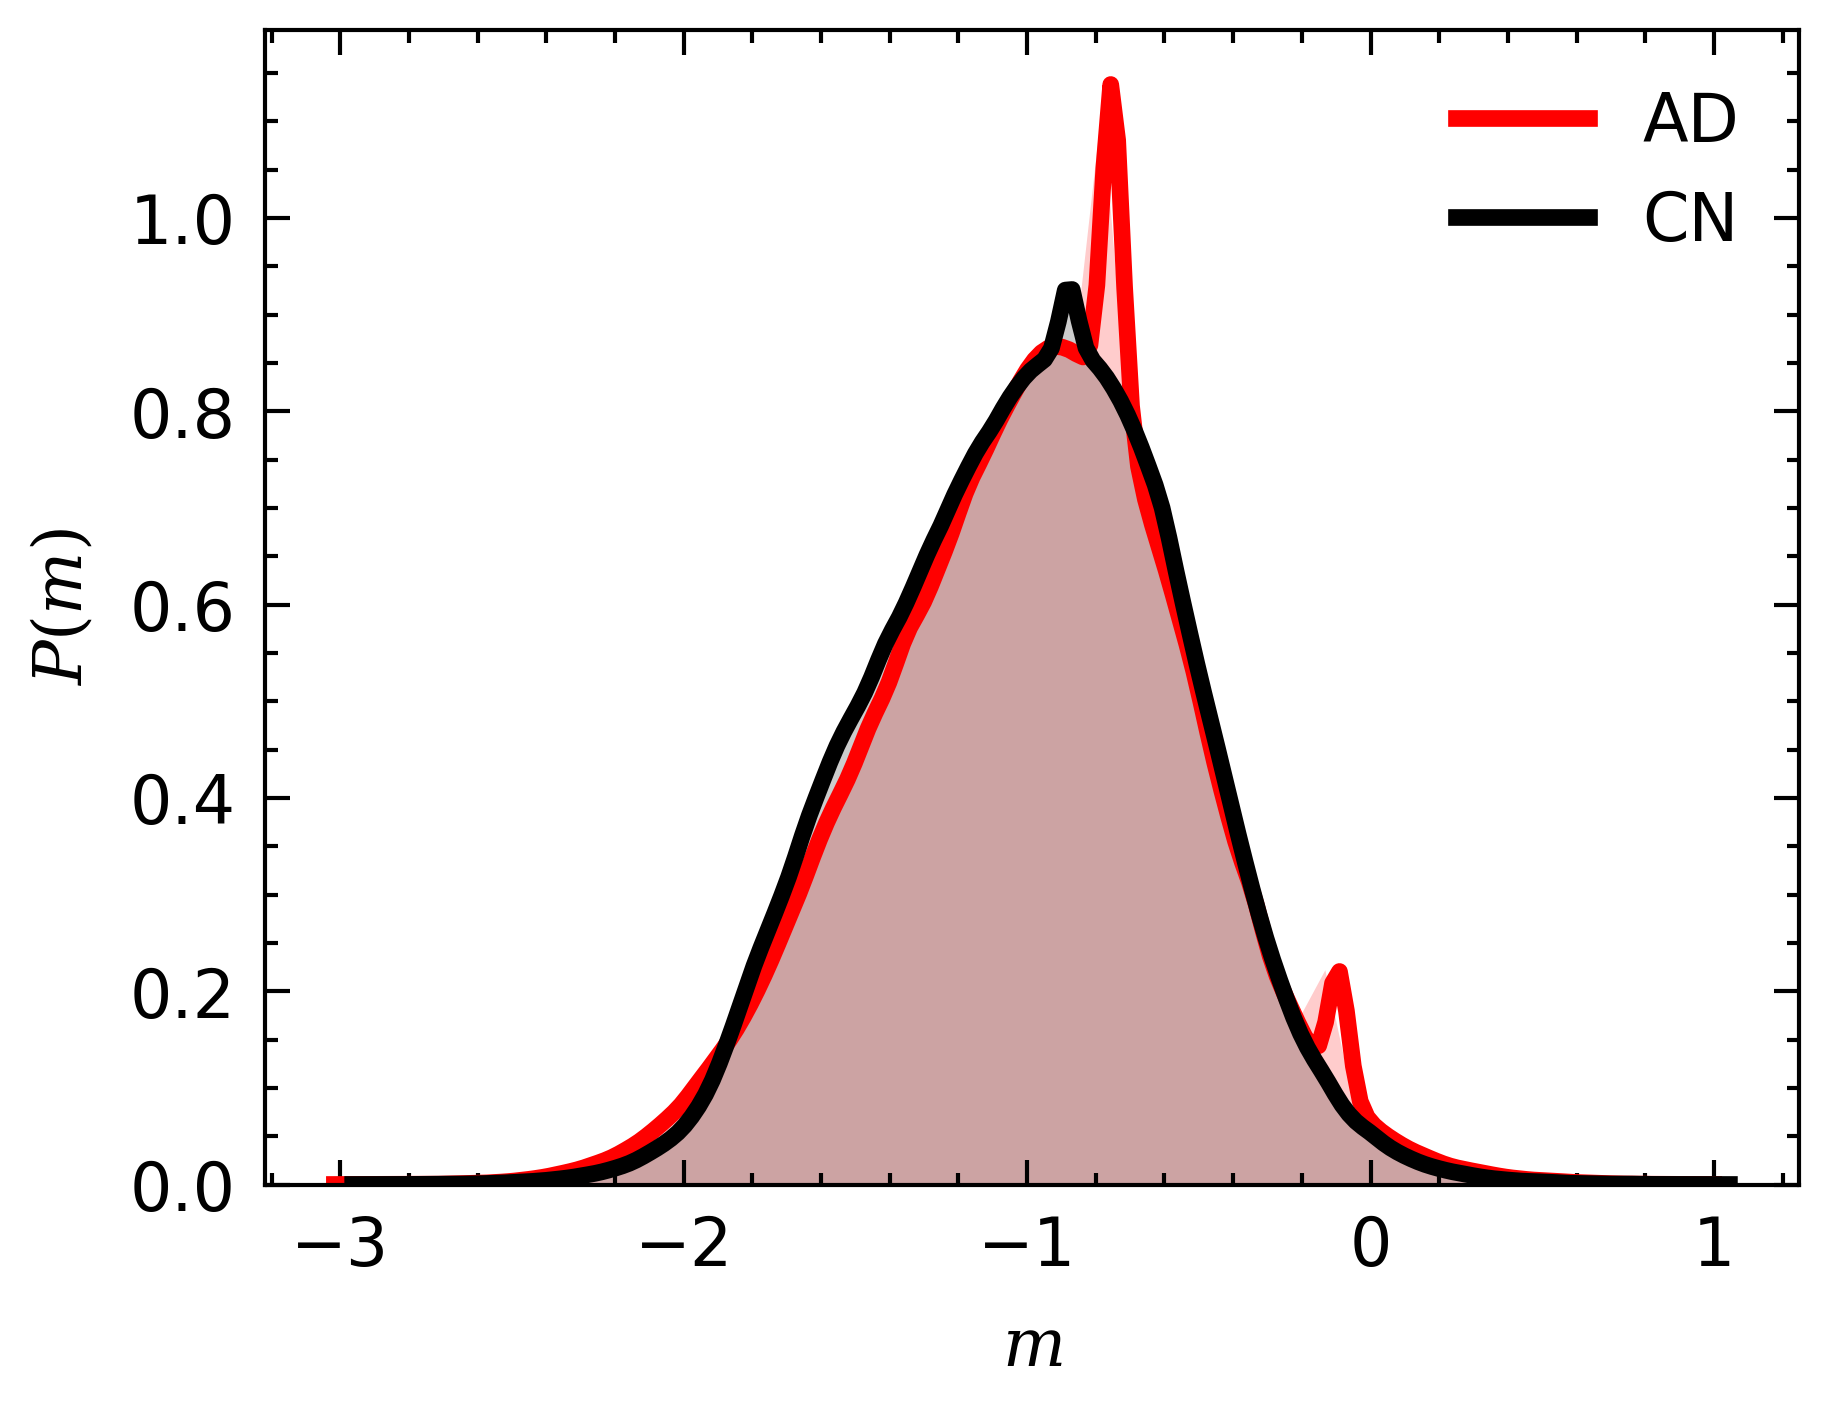

In [24]:
bins = np.histogram_bin_edges(np.concatenate([ad_exps[~np.isnan(ad_exps)], cn_exps[~np.isnan(cn_exps)]]), bins=50)


sns.histplot(
    ad_exps, color='red', bins=bins, kde=True, stat='density',   
    element='poly', linewidth=0, alpha=0.2, line_kws={ 'linewidth': 2, 'linestyle': '-', 'label':'AD' }
)
sns.histplot(
    cn_exps, color='black', bins=bins, kde=True, stat='density', 
    element='poly', linewidth=0, alpha=0.2, line_kws={ 'linewidth': 2, 'linestyle': '-', 'label':'CN' }
)
# plt.hist(ad_exps, color='red', label='AD', alpha=0.8)
# plt.hist(cn_exps,color='black',label='CN', alpha=0.4)
plt.legend()
plt.xlabel('$m$')
plt.ylabel('$P(m)$')
plt.savefig('results/plots/psds_distribution.svg', dpi=1200)
plt.savefig('results/plots/psds_distribution.pdf', dpi=1200)